Věrohodnost

In [1]:
import numpy as np
import pandas as pd 


import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy
import seaborn as sns
import json
from zipfile import ZipFile

### 1)
Weibullovo rozdelenie
$$
f(x) = 
= 
\begin{cases}
\frac{k}{\lambda}(\frac{x}{\lambda}^{k-1})\text{e}^{-(\frac{x}{\lambda})^k} & \text{ if } x \geq 0.5\\
0 & \text{ if } x < 0.5
\end{cases}
$$

$$ 
k \in (0, \infty) 
$$ 
k je shape,tvar parameter
$$ 
\lambda \in (0, \infty) 
$$ 
λ je scale, meritko parameter

#### Logaritmická-verohodnostna funkcia
$$
l(k, \lambda) = n*\ln{k} - n*k*\ln{\lambda} + (k+1) * \sum_{i=1}^{n} \ln{x_{i}} - \sum_{i=1}^{n} (\frac{x_{i}}{\lambda})^k
$$

#### Parciálna derivácia podľa parametru shape
$$
\frac{\partial l}{\partial k} = \frac{n}{k} - n*\ln{\lambda} + \sum_{i=1}^{n} \ln{x_{i}} - \sum_{i=1}^{n} (\ln{x_{i}} - \ln{\lambda}) * (\frac{x_{i}}{\lambda})^k
$$
#### Parciálna derivácia podľa parametru scale
$$
\frac{\partial l}{\partial \lambda} = - \frac{n*k}{\lambda} + \frac{k}{\lambda^{k+1}} * \sum_{i=1}^{n} x_{i}^{k}
$$

In [2]:
# load data
fileName = "Data_2024.xlsx"
df = pd.read_excel(fileName, sheet_name="Data_věrohodnost") # need pip install xlrd and openpyxl
df = df.iloc[:, :-2] # remove columns without information
# check types
df['censored'] = df['censored'].astype(int)
df['doba práce v oboru [roky]'] = df['doba práce v oboru [roky]'].astype(float)
print(df)

     censored  doba práce v oboru [roky]
0           0                      6.528
1           0                      6.013
2           1                      6.055
3           0                      7.243
4           1                      5.629
..        ...                        ...
316         1                      5.562
317         0                      5.491
318         0                      6.761
319         0                      7.062
320         0                      5.784

[321 rows x 2 columns]


### 2) MLE parametrov

In [78]:
x = df['doba práce v oboru [roky]'].values
censored = df['censored'].values

# logaritmicka-verohodnostna funkcia
def log_likelihood(params):
    k, lamb = params
    # log density - log z pdf
    log_pdf = np.log(k) - np.log(lamb) * k + (k-1) * np.log(x) - ((x/lamb) ** k)
    sf = np.exp(-(x / lamb)**k)  # survivor funkcia - z CDF
    # logaritmická verohodnost
    log_l = (1 - censored) * log_pdf + censored * np.log(sf)
    return -np.sum(log_l)  # negácia pre minimalizaciu

# pociatocne odhady
initial_params = [1.0, 1.0]

# optimalizácia
result = optimize.minimize(log_likelihood, initial_params, method='L-BFGS-B')

# výsledky
if result.success:
    k_mle, lam_mle = result.x
    print(f"Odhadnuté parametry: k = {k_mle:.4f}, λ = {lam_mle:.4f}")
else:
    print("Optimalizace selhala:", result.message)

Odhadnuté parametry: k = 6.1728, λ = 7.4295


$$\hat k = 6.1728 $$

$$\hat λ = 7.4295$$

### 3) Test verohodnostnym pomerom

In [ ]:
# zafixuj k na 1 a odhadni MLE znovu
x = df['doba práce v oboru [roky]'].values
censored = df['censored'].values

# logaritmicka-verohodnostna funkcia
def log_likelihood(k_fix, lamb):
    k = k_fix
    # log density - log z pdf
    log_pdf = np.log(k) - np.log(lamb) * k + (k-1) * np.log(x) - ((x/lamb) ** k)
    sf = np.exp(-(x / lamb)**k)  # survivor funkcia - z CDF
    # logaritmická verohodnost
    log_l = (1 - censored) * log_pdf + censored * np.log(sf)
    return -np.sum(log_l)  # negacia pre minimalizaciu

# pociatocne odhady
initial_lamb = [1.0]
k_fix = 1.0

# optimalizacia
result_exp = optimize.minimize(lambda lamb:log_likelihood(k_fix, lamb), initial_lamb, method='L-BFGS-B', bounds=[(1e-5, None)])

# vysledky
if result_exp.success:
    lam_exp_mle = result_exp.x[0]
    print(f"Odhadnutý parameter: λ = {lam_exp_mle:.4f}")
else:
    print("Optimalizace selhala:", result_exp.message)

print(result_exp.fun)

Odhadnutý parameter: λ = 9.0533
746.3288140610031


In [87]:
lr = -2*(-result_exp.fun - (-result.fun))
print(lr)

592.3898153434229


Test
$$
H_0: k = 1 \text{Stačí exponenciálne rozdelenia.}
$$
$$
H_A: k \neq 1 \text{Exponenciálne rozdelenia nestačí.}
$$
$$
stupne volnosti 2 - 1 = 1
W'_0.05 = <0,\Chi^2 0.95(1)> = <0, 3.841>
$$
testova statistika = 592.39 nelezi v kritickom obore, preto $H_0$ zamietam

### 4) Bodové odhady pre strednu dobu zamestania v obore 
10% percentil zamestnania v obore

In [102]:
import scipy
# stredna hodnota weibull náhodnej premennej je stredna hodnota času v odbore
Ex = lam_mle * scipy.special.factorial((1 + 1/k_mle) - 1)
print(f"Stredna doba zamestnania v obore je {Ex:.4f} rokov.")

# 10% zamestnanie v odbore
p = 0.1
percentile = lam_mle * (-np.log(1-p))**(1/k_mle)
print(f"10% percentil zamestnania v obore je {percentile:.4f} rokov.")

Stredna doba zamestnania v obore je 6.9032 rokov.
10% percentil zamestnania v obore je 5.1598 rokov.


Odpoveď: 
Stredna doba zamestnania v obore je 6.9032 rokov.
10% percentil zamestnania v obore je 5.1598 rokov.

Väčšina ľudí pracuje obore do 7 rokov, desať percent ľudí zmení obor po piatich rokoch. 

Regrese

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from matplotlib import cm

In [2]:
# načítaj dáta z xlsx súboru
fileName = "Data_2024.xlsx"
df = pd.read_excel(fileName, sheet_name="Data_regrese") # potrebujem pip install xlrd and openpyxl
# skontroluj typy
df['ActiveUsers'] = df['ActiveUsers'].astype(int)
df['InteractingPct'] = df['InteractingPct'].astype(float)
df['ScrollingPct'] = df['ScrollingPct'].astype(float)
df['Ping [ms]'] = df['Ping [ms]'].astype(float)
print(df)

      OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0        iOS         4113          0.8283        0.1717       47.0
1        iOS         7549          0.3461        0.6539       46.0
2    Windows         8855          0.2178        0.7822       55.0
3    Android         8870          0.0794        0.9206       56.0
4      MacOS         9559          0.7282        0.2718       76.0
..       ...          ...             ...           ...        ...
497      iOS         5315          0.1974        0.8026       28.0
498    MacOS         1392          0.2373        0.7627       24.0
499      iOS         6014          0.8112        0.1888       54.0
500  Android         5118          0.2345        0.7655       39.0
501    MacOS         2660          0.9390        0.0610       55.0

[502 rows x 5 columns]


In [3]:
print(df["OSType"].unique()) # ktoré OS sú v dátach

['iOS' 'Windows' 'Android' 'MacOS']


In [4]:
# nahrad OSType stlpec s one-hot encoding ekvivalentom
df = pd.concat([df.drop(columns=["OSType", ]), pd.get_dummies(df["OSType"])], axis=1)
#  premenuj ping aby sa dal pouzit v ols formuly
df = pd.concat([df.drop(columns=["Ping [ms]"]), df["Ping [ms]"].rename("ping")], axis=1)
print(df)

     ActiveUsers  InteractingPct  ScrollingPct  Android  MacOS  Windows  \
0           4113          0.8283        0.1717    False  False    False   
1           7549          0.3461        0.6539    False  False    False   
2           8855          0.2178        0.7822    False  False     True   
3           8870          0.0794        0.9206     True  False    False   
4           9559          0.7282        0.2718    False   True    False   
..           ...             ...           ...      ...    ...      ...   
497         5315          0.1974        0.8026    False  False    False   
498         1392          0.2373        0.7627    False   True    False   
499         6014          0.8112        0.1888    False  False    False   
500         5118          0.2345        0.7655     True  False    False   
501         2660          0.9390        0.0610    False   True    False   

       iOS  ping  
0     True  47.0  
1     True  46.0  
2    False  55.0  
3    False  56.0  
4   

Plný kvadratický model je:
$$
\displaystyle
\begin{align*}
\text{Ping} &= \beta_0 + \beta_1 \text{ActiveUsers} + \beta_2 \text{InteractingPct} + \beta_3 \text{ScrollingPct} \\
&+ \beta_4 \text{iOS} + \beta_5 \text{Windows} + \beta_6 \text{Android}\\
&+ \beta_{11} (\text{ActiveUsers}^2) + \beta_{22} (\text{InteractingPct}^2) + \beta_{33} (\text{ScrollingPct}^2) \\
&+ \beta_{12} ( \text{ActiveUsers} \cdot \text{InteractingPct}) + \beta_{13} ( \text{ActiveUsers} \cdot \text{ScrollingPct}) \\
&+ \beta_{23} ( \text{InteractingPct} \cdot \text{ScrollingPct}) \\
&+ \beta_{14} ( \text{ActiveUsers} \cdot \text{iOS}) + \beta_{15} ( \text{ActiveUsers} \cdot \text{Windows}) + \beta_{16} ( \text{ActiveUsers} \cdot \text{Android}) \\
&+ \beta_{24} ( \text{InteractingPct} \cdot \text{iOS}) + \beta_{25} ( \text{InteractingPct} \cdot \text{Windows}) + \beta_{26} ( \text{InteractingPct} \cdot \text{Android}) \\
&+ \beta_{34} ( \text{ScrollingPct} \cdot \text{iOS}) + \beta_{35} ( \text{ScrollingPct} \cdot \text{Windows}) + \beta_{36} ( \text{ScrollingPct} \cdot \text{Android})
+ \epsilon
\end{align*}
$$

In [5]:
# definuj funkciu pre zostavenie modelu a zobrazenie summary, VIF a korelacie prediktorov
def buildModelRunStats(formula, dframe):
    model=smf.ols(formula=formula,data=dframe) # přepiš původní (lineární) model
    results=model.fit()
    print(results.summary())
    #upozorni na významnost koeficientů, R^2 atp
    # získej VIF a slož všechny VIF do dataframe
    X = pd.DataFrame(model.exog, columns=model.exog_names)
    vif = pd.Series([variance_inflation_factor(X.values, i)
                    for i in range(X.shape[1])],
                    index=X.columns)
    vif_df = vif.to_frame()
    # Nastavení názvu sloupce
    vif_df.columns = ['VIF']
    print('\n\n\n')
    print("VIF")
    print(vif_df)
    #ukaž korelaci prediktorů
    print('\n\n\n')
    print("Compute pairwise correlation of columns")
    print(X.corr())

def buildModelSummary(formula, dframe):
    model=smf.ols(formula=formula,data=dframe) # přepiš původní (lineární) model
    results=model.fit()
    print(results.summary())
    return results

def buildModelPrintVIF(formula, dframe):
    model=smf.ols(formula=formula,data=dframe) # přepiš původní (lineární) model
    #upozorni na významnost koeficientů, R^2 atp
    # získej VIF a slož všechny VIF do dataframe
    X = pd.DataFrame(model.exog, columns=model.exog_names)
    vif = pd.Series([variance_inflation_factor(X.values, i)
                    for i in range(X.shape[1])],
                    index=X.columns)
    vif_df = vif.to_frame()
    # Nastavení názvu sloupce
    vif_df.columns = ['VIF']
    print("VIF")
    print(vif_df)

In [6]:
formula = 'ping~ActiveUsers + InteractingPct + ScrollingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + I(ScrollingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:ScrollingPct + InteractingPct:ScrollingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android + ScrollingPct:iOS + ScrollingPct:Windows + ScrollingPct:Android'
buildModelRunStats(formula, df)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        14:51:12   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [7]:
buildModelPrintVIF(formula, df)

VIF
                                         VIF
Intercept                       0.000000e+00
iOS[T.True]                              inf
Windows[T.True]                          inf
Android[T.True]                          inf
ActiveUsers                              inf
ActiveUsers:iOS[T.True]         7.902726e+00
ActiveUsers:Windows[T.True]     8.874288e+00
ActiveUsers:Android[T.True]     9.633112e+00
InteractingPct                           inf
InteractingPct:iOS[T.True]      1.000800e+15
InteractingPct:Windows[T.True]           inf
InteractingPct:Android[T.True]  4.503600e+15
ScrollingPct                             inf
ScrollingPct:iOS[T.True]        1.125900e+15
ScrollingPct:Windows[T.True]             inf
ScrollingPct:Android[T.True]             inf
I(ActiveUsers ** 2)             2.249913e+01
I(InteractingPct ** 2)                   inf
I(ScrollingPct ** 2)                     inf
ActiveUsers:InteractingPct               inf
ActiveUsers:ScrollingPct                 inf
Intera

c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\marti\anaconda3\envs\aidojo\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [8]:
# overenie korelacie
correlationOut = df[["InteractingPct", "ScrollingPct"]].corr()
print(correlationOut)

                InteractingPct  ScrollingPct
InteractingPct             1.0          -1.0
ScrollingPct              -1.0           1.0


Podľa riadku: InteractingPct:ScrollingPct                     1.000000

existuje perfektná korelácia medzi závislými premennými InteractingPct a ScrollingPct, preto použijem len jednu. Ďalej som zvolil, že budem používať InteractingPct.

In [9]:
# formula bez ScrollingPct
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android'
buildModelRunStats(formula, df)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        14:51:21   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [10]:
# bez ScrollingPct
buildModelPrintVIF(formula, df)

VIF
                                      VIF
Intercept                       63.383605
iOS[T.True]                     11.433318
Windows[T.True]                 12.043616
Android[T.True]                 12.635613
ActiveUsers                     27.109807
ActiveUsers:iOS[T.True]          7.902726
ActiveUsers:Windows[T.True]      8.874288
ActiveUsers:Android[T.True]      9.633112
InteractingPct                  23.371802
InteractingPct:iOS[T.True]       4.956296
InteractingPct:Windows[T.True]   5.724508
InteractingPct:Android[T.True]   5.395430
I(ActiveUsers ** 2)             22.499134
I(InteractingPct ** 2)          16.060875
ActiveUsers:InteractingPct       8.851002


Existuje korelácia medzi ActiveUsers a InteractingPct
použijem z-scores $\frac{x-\bar{x}}{s(x)}$ štandardizácia na 0 priemer a 1 smerodatnú odchylku 

In [11]:
dfSt=df.copy()
# odcitaj priemer a podel smerodatnou odchylkou
dfSt['ActiveUsers']=(dfSt['ActiveUsers']-dfSt['ActiveUsers'].mean())/dfSt['ActiveUsers'].std()
dfSt['InteractingPct']=(dfSt['InteractingPct']-dfSt['InteractingPct'].mean())/dfSt['InteractingPct'].std()

In [12]:
# so standardizaciou ActiveUsers a InteractingPct
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android'
buildModelRunStats(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        14:51:26   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [13]:
# so standardizaciou ActiveUsers a InteractingPct
buildModelPrintVIF(formula, dfSt)

VIF
                                     VIF
Intercept                       6.563938
iOS[T.True]                     1.452802
Windows[T.True]                 1.482116
Android[T.True]                 1.438849
ActiveUsers                     3.794151
ActiveUsers:iOS[T.True]         1.960285
ActiveUsers:Windows[T.True]     2.075749
ActiveUsers:Android[T.True]     1.823575
InteractingPct                  3.246008
InteractingPct:iOS[T.True]      1.807510
InteractingPct:Windows[T.True]  1.746695
InteractingPct:Android[T.True]  1.710475
I(ActiveUsers ** 2)             1.019635
I(InteractingPct ** 2)          1.032984
ActiveUsers:InteractingPct      1.041103


Teraz je VIF akceptovateľný (VIF < 10).
Môžem začať so spätnou elimináciou, eliminujem kým nedosiahnem p < 0.05 pre všetky interakcie.

In [18]:
# este raz spustim so standardizaciou ActiveUsers a InteractingPct
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows + InteractingPct:Android'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        14:52:18   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Najväčšia hodnota je 0.888 pre InteractingPct:Android, preto tento člen vymažem

In [20]:
# vymazany InteractingPct:Android
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:iOS + InteractingPct:Windows'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          3.60e-187
Time:                        14:52:29   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Ďalší bol člen InteractingPct:iOS 0.828

In [21]:
# vymazany InteractingPct:iOS
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android + InteractingPct:Windows'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          2.43e-188
Time:                        14:52:33   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

InteractingPct:Windows 0.821 

In [22]:
# bez InteractingPct:Windows
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + I(InteractingPct**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android'
buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.57e-189
Time:                        14:52:38   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3272.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

I(InteractingPct ** 2) 0.278 

In [23]:
# bez I(InteractingPct ** 2)
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android'
resModel = buildModelSummary(formula, dfSt)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        14:52:49   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Už neostali žiadne členy s p-hodnotou >= 0.05.

Rovnica modelu po spätnej eliminácii

Ešte bude treba odstraniť outliery a potom dostanem finálny model
$$
\displaystyle
\begin{align*}
\text{Ping} &= \beta_0 + \beta_1 \text{ActiveUsers} + \beta_2 \text{InteractingPct} \\
&+ \beta_4 \text{iOS} + \beta_5 \text{Windows} + \beta_6 \text{Android}\\
&+ \beta_{11} (\text{ActiveUsers}^2) \\
&+ \beta_{12} ( \text{ActiveUsers} \cdot \text{InteractingPct})  \\
&+ \beta_{14} ( \text{ActiveUsers} \cdot \text{iOS}) + \beta_{15} ( \text{ActiveUsers} \cdot \text{Windows}) \\
&+ \beta_{16} ( \text{ActiveUsers} \cdot \text{Android}) + \epsilon
\end{align*}
$$

##### Kontrola či dáta neobsahujú outliery.
Najskôr si zobrazím graf reziduí a potom spočítam Cookovu vzdialenosť.

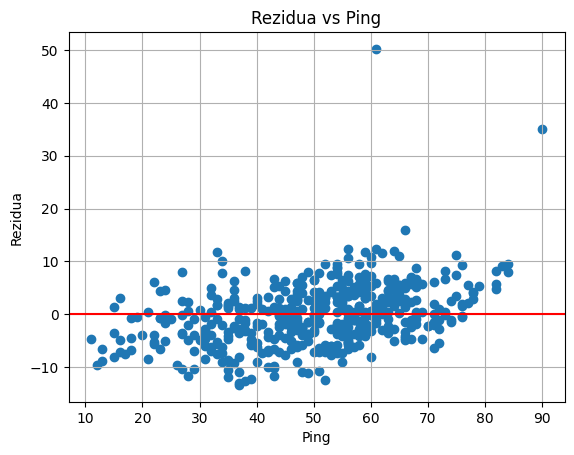

In [24]:
# graf rezidui
# res vs ping
plt.scatter(dfSt['ping'], resModel.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.title("Rezidua vs Ping")
plt.xlabel("Ping")
plt.ylabel("Rezidua")

plt.show()

In [25]:
influence = resModel.get_influence()
# Leverage
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) jako n-tice polí [n x 2]
cooks_d = influence.cooks_distance
# Standardizovaná rezidua
standardized_residuals = influence.resid_studentized_internal
# Studentizovaná rezidua
studentized_residuals = influence.resid_studentized_external

#tabulka dohromady dořešit změny počtu řádků
outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=dfSt.index)
#vyber jen "zajímavý" hodnoty
outl_stats_df = outl_stats_df[(outl_stats_df['Leverage'] > 3*len(resModel.params)/dfSt.shape[0]) | (np.abs(outl_stats_df['Standardized Residuals']) > 2) | (outl_stats_df['Cook\'s Distance_p-value'] < 0.05)]


print(outl_stats_df)

     Leverage  Standardized Residuals  Studentized Residuals  Cook's Distance  \
62   0.012590               -2.036977              -2.043554         0.004810   
82   0.010646                2.699228               2.716710         0.007127   
114  0.012955                2.111260               2.118748         0.005318   
129  0.014222               -2.141213              -2.149089         0.006013   
145  0.023780               -2.292470              -2.302490         0.011638   
178  0.047086                2.054883               2.061673         0.018968   
254  0.011482                2.011917               2.018204         0.004274   
255  0.009986                5.945469               6.165493         0.032412   
310  0.016649               -2.111115              -2.118601         0.006860   
332  0.030075                2.124928               2.132592         0.012728   
428  0.028086                2.048785               2.055502         0.011027   
430  0.017414               

Podľa grafu reziduí je vidieť, že sa dve hodnoty veľmi líšia od ostatných - sú to hľadané outliery. Podľa výpočtu štandardizovaných a študentizovaných reziduí sú najviac líšiace sa merania s indexmi 255 a 476. Preto ich v ďalšom kroku odstránim a znovu vizualizujem graf reziduí.

In [26]:
# vymazanie outlierov
outlierIndxs = [255,476]
print(f"Drop: {outlierIndxs}")
dfStNoOut = dfSt.drop(index=outlierIndxs)

Drop: [255, 476]


#### Finálny model

In [27]:
# model bez outlierov
formula = 'ping~ActiveUsers + InteractingPct + iOS + Windows + Android + I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:iOS + ActiveUsers:Windows + ActiveUsers:Android'
finalModel = buildModelSummary(formula, dfStNoOut)

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        14:53:25   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

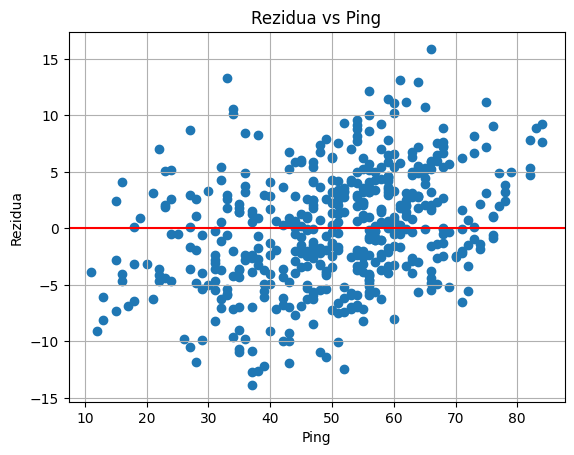

In [28]:
# graf rezidui
# res vs ping
plt.scatter(dfStNoOut['ping'], finalModel.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.title("Rezidua vs Ping")
plt.xlabel("Ping")
plt.ylabel("Rezidua")

plt.show()

Odstránil som správne dve hodnoty a model sa podľa koeficientu determinácie zlepšil z 0.843 na 0.877. Odstránené hodnoty mohli byť valídne avšak bolo by potreba viac dát s podobnými hodnotami aby som ich mohol použiť.

Teraz je model hotový.

#### Regresia 1 a) výsledný model aj s hodnotami

$$
\displaystyle
\begin{align*}
\text{Ping} &= 60.3010 + 14.4830 \cdot \text{ActiveUsers} + 5.1410 \cdot \text{InteractingPct} \\
&+ (-14.7296) \cdot \text{iOS} + (-5.3416) \cdot \text{Windows} + (-9.0073) \cdot \text{Android}\\
&+ (-3.0081) \cdot (\text{ActiveUsers}^2) \\
&+ (-2.5596) \cdot ( \text{ActiveUsers} \cdot \text{InteractingPct})  \\
&+ (-7.1797) \cdot ( \text{ActiveUsers} \cdot \text{iOS}) + (-6.3501) \cdot ( \text{ActiveUsers} \cdot \text{Windows}) \\
&+ (-4.4373) \cdot ( \text{ActiveUsers} \cdot \text{Android}) + \epsilon
\end{align*}
$$

#### Regresia 1 b) Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky

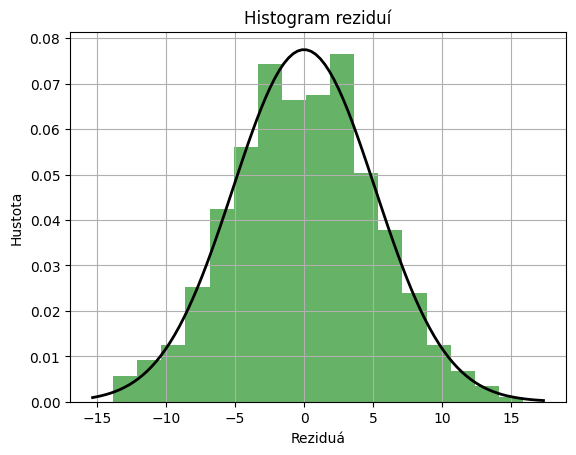

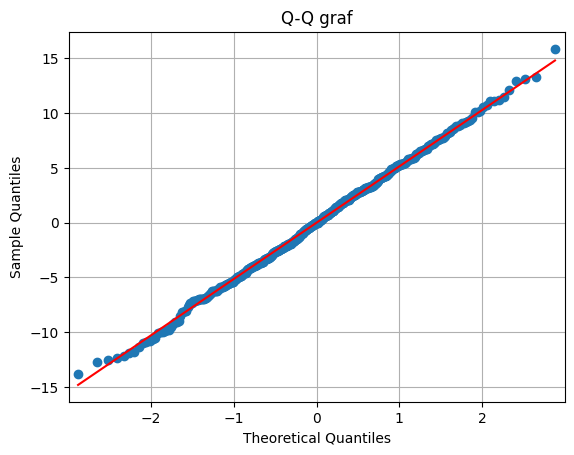

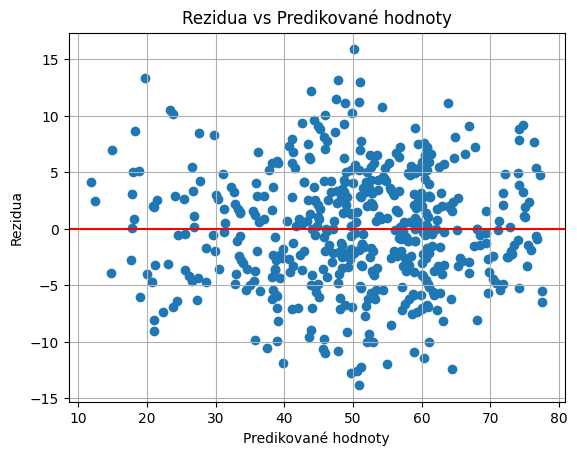

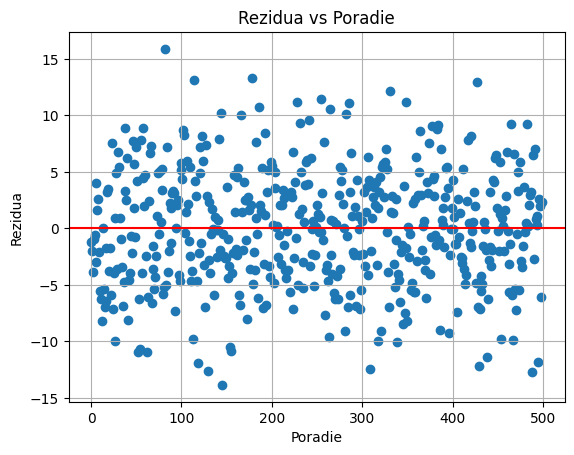

In [34]:
# histogram reziduí - test normality reziduí
plt.hist(finalModel.resid, bins='auto', density=True, alpha=0.6, color='g')

# vykreslení odpovedajúcej Gaussovej krivky
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(finalModel.resid), np.std(finalModel.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.grid(True)
plt.title("Histogram reziduí")
plt.xlabel("Reziduá")
plt.ylabel("Hustota")

plt.show()

#q-q plot - kontrola normality reziduí
qqplot(finalModel.resid, line='s')
plt.title('Q-Q graf')
plt.grid(True)
plt.show()

#res vs fit - kontrola homoskedascity
plt.scatter(finalModel.fittedvalues, finalModel.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# res vs order - kontrola časovej závislosti / autokorelácie
plt.scatter(range(len(finalModel.resid)), finalModel.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.title("Rezidua vs Poradie")
plt.xlabel("Poradie")
plt.ylabel("Rezidua")
plt.show()

Regresia 1 b)
Podľa 'histogramu reziduí' a 'Q-Q grafu' majú reziduá normálne rozdelenie.

Graf 'rezidua vs predikované hodnoty' testuje homoskedascitu a graf ukazuje, že reziduá majú rovnakú odchylku v rámci všetkých predikovaných hodnôt.

Graf 'rezidua vs poradie' kontroluje časovú závislosť, hodnoty v ňom sú náhodne rozmiestnené, čo znamená, že reziduá sú na sebe nezávislé. Tiež tu nepozorujem žiadne outliery, nakoľko som už hlavné dva odstránil.

Výsledok summary:
```
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.750
Skew:                           0.014   Prob(JB):                        0.687
Kurtosis:                       2.812   Cond. No.                         7.16
==============================================================================
```

Omnibus a Jarque-Bera testy testujú normalitu reziduí, obidva testy vyšli väčšie ako 0.05, čo značí, že nenastala významná odchylka od normality.

Durbin-Watsonova štatistika vyšla 1.990, čo znamená, že tu nie je autokorelácia, lebo je blízko 2, v rozsahu <1.5, 2.5>.

Šikmosť - Skew vyšla 0.014, čo je blízko 0, to znamená, že reziduá sú takmer úplne symetrické, pretože 0 značí symetriu reziduí.
Špičatosť - Kurtosis vyšla 2.812, normálne rozdelenie má 3, 2.812 je rozumne blízko, takže reziduá sú takmer normálne.

Číslo podmienenosti matice plánu je 7.16, to považujem za dostatočne malé, a teda neznačí multikolinearitu. Nad 30 by značilo multikolinearitu.

Všetky predpoklady lineárnej regresie, normálnosť, nezávislosť reziduí, homoskedascita aj absencia autokorelácie a multikolinearity sú splnené.

####  Regresia 1 c) Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění, vyřadit

Vyradil som hodnoty s indexmi 255 a 476, ktoré som identifikoval vyššie popísaným postupom.

### Regresia 2 Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější (největší) hodnotu (použijte model, nikoli samotná pozorování)

Najproblematickejšiu hodnotu nájdem predikciou závislej hodnoty "ping" pomocou výsledného modelu. Z výsledku predikcie nájdem najväčšiu hodnotu a zistím z ktorých parametrov bola predikovaná.

In [55]:
ping_predicted = finalModel.predict(sm.add_constant(dfStNoOut))
print(f"Najvyšší ping: {np.max(ping_predicted)}")
print(f"Index naššieho predikovaného ping: {np.argmax(ping_predicted)}")
print(f"Ping na indexe 10: {ping_predicted[10]}")
print(f"\nProblematické hodnoty:\n{dfStNoOut.iloc[10]}")

Najvyšší ping: 77.50462838943069
Index naššieho predikovaneho ping: 10
Ping na indexe 10: 77.50462838943069

Problematické hodnoty:
ActiveUsers       1.636436
InteractingPct    1.636444
ScrollingPct         0.027
Android              False
MacOS                 True
Windows              False
iOS                  False
ping                  72.0
Name: 10, dtype: object


Odozva (ping) má najproblematickejšiu hodnotu 77.50 pre nastavenie parametrov OsType = MacOs, ActiveUsers = 1.636436, InteractingPct = 1.636444. Pričom hodnoty ActiveUsers a InteractingPct sú normalizované.

### Regresia 3 Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.
Najskôr si vypočítam priemerné nastavenie ostatných parametrov.

In [37]:
meanVals = dfStNoOut.mean()
meanVals['Android'] = 0.0
meanVals['MacOS'] = 0.0
meanVals['Windows'] = 1.0 # iba Windows používatelia
meanVals['iOS'] = 0.0
meanVals = meanVals.drop('ScrollingPct') # nepoužíva sa

#print(f"Priemerné hodnoty a OS nastavený na Windows:\n{meanVals}")

windowsUsers = pd.DataFrame([meanVals])

prediction = finalModel.predict(windowsUsers)
print(f"\nOdhadnutý ping: {prediction.iloc[0]}")

# konfidenčný interval
# https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.PredictionResultsMean.summary_frame.html
prediction_res = finalModel.get_prediction(windowsUsers)
predConf = prediction_res.summary_frame(alpha=0.05)
minConf = predConf.iloc[0]["mean_ci_lower"]
maxConf = predConf.iloc[0]["mean_ci_upper"]
print(f"Konfidenčný interval je <{minConf},{maxConf}>")

# predikčný interval
minPred = predConf.iloc[0]["obs_ci_lower"]
maxPred = predConf.iloc[0]["obs_ci_upper"]
print(f"Konfidenčný interval je <{minPred},{maxPred}>")


Odhadnutý ping: 55.00268869925897
Konfidenčný interval je <53.972144957662586,56.03323244085535>
Konfidenčný interval je <44.72469273780247,65.28068466071547>


Odhadnutá hodnota odozvy pre užívateľa Windows je 55.0027 ms. 

Konfidenčný interval je <53.972144957662586, 56.03323244085535>.

Predikčný interval je <44.72469273780247, 65.28068466071547>.

### Regresia 4 Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“ pro další použití.

Koeficient determinácie 0.877 značí, že model pomerne dobre popisuje dáta. Model spĺňa podmienky regularity (popísané v 1 b)). Preto je model možné použiť, avšak bol vytvorený na vzorke len 502 dát, z čoho som 2 hodnoty vyradil, nakoľko boli outliery a narušovali model. Pri väčšom množstve dát by som však mohol zistiť, že tieto hodnoty boli valídne. V tomto prípade by bolo použitie modelu nevhodné, keby však boli outliery skutočne len chybné hodnoty, model by sa mohol používať. Predikcie na trénovacích dátach boli podľa môjho názoru rozumné, avšak by bolo vhodné pred ďalším použitím modelu, model overiť na testovacej sade, ktorú ešte model 'nevidel'.